In [1]:
from __future__ import (absolute_import, division, print_function)
import pandas as pd
from pandas import DataFrame
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras
import json
import os

In [2]:
data_path = "."

def pgconnect(credential_filepath, db_schema="public"):
    # please replace <your_unikey> and <your_SID> with your own details in the credentials file!
    with open(credential_filepath) as f:
        db_conn_dict = json.load(f)
        HOST       = db_conn_dict['host']
        DB_USER    = db_conn_dict['user']
        DB_PW      = db_conn_dict['password']
        DEFAULT_DB = db_conn_dict['user']

        try:
            db = create_engine('postgresql+psycopg2://'+DB_USER+':'+DB_PW+'@'+HOST+'/'+DEFAULT_DB, echo=False)
            conn = db.connect()
            print('connected')
        except Exception as e:
            print("unable to connect to the database")
            print(e)
        return db,conn

credfilepath = os.path.join(data_path, "data2x01_db.json")
# credfilepath = os.path.join(data_path, "data2001_dbadmin.json") # An extra credential set that we won't be using


In [3]:
db,conn = pgconnect(credfilepath)

connected


In [4]:
print(db.table_names())

['spatial_ref_sys', 'test', 'rfs_sa2_density', 'neighbourhoods', 'businessstats', 'MeasurementWk4', 'statisticalareas', 'rfsnsw_bfpl', 'sa2_2016_aust', 'wetlands', 'rfs_sa2_join', 'bfpl_density', 'wl_sa2_join', 'fire_risk_computations', 'forecasts', 'fire_risk_z_scores']


In [5]:
#Drop all existing table
# reset the businessstats
conn.execute("DROP TABLE IF EXISTS businessstats")
# reset the statisticalareas
conn.execute("DROP TABLE IF EXISTS statisticalareas")
# reset the fire_risk_scores
conn.execute("DROP TABLE IF EXISTS fire_risk_z_scores")
# reset the fire_risk_computations
conn.execute("DROP TABLE IF EXISTS fire_risk_computations")
# reset rfs_sa2_join
conn.execute("DROP TABLE IF EXISTS rfs_sa2_join")
# reset rfsnsw_bfpl
conn.execute("DROP TABLE IF EXISTS rfnsw_bfpl")
# reset bfpl_density
conn.execute("DROP TABLE IF EXISTS bfpl_density")
# reset sa2_2016_aust
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")
# reset wetlands
conn.execute("DROP TABLE IF EXISTS wetlands")
# reset neighbourhoods
conn.execute("DROP TABLE IF EXISTS neighbourhoods")
# reset forecasts
conn.execute("DROP TABLE IF EXISTS forecasts")

In [6]:
# if you want to reset the table
conn.execute("DROP TABLE IF EXISTS neighbourhoods_raw")

# 2nd: ensure that the schema is in place
neighbourhood_schema = """CREATE TABLE IF NOT EXISTS neighbourhoods_raw (
          area_id    INTEGER NOT NULL,
          area_name  TEXT,
          land_area  FLOAT,
          population INTEGER,
          number_of_dwellings INTEGER,
          number_of_businesses INTEGER,
          median_annual_household_income INTEGER,
          avg_monthly_rent INTEGER, 
          PRIMARY KEY (area_id));"""

conn.execute(neighbourhood_schema)

# 3rd: load the data from CSV into a dataframe using pandas
data_neighbourhood = pd.read_csv('Neighbourhoods.csv')

data_neighbourhood.fillna(0)
# 3.1 Data Wrangling 
#Change Data Types
data_neighbourhood['population'] = data_neighbourhood['population'].str.replace(',', '').fillna(0).astype(int)
data_neighbourhood['number_of_dwellings'] = data_neighbourhood['number_of_dwellings'].str.replace(',', '').fillna(0).astype(int)
data_neighbourhood['number_of_businesses'] = data_neighbourhood['number_of_businesses'].fillna(0).astype(int)
# 4th: load data from pandas dataframe into the database
table_name = "neighbourhoods_raw"

data_neighbourhood.to_sql(table_name, con=conn, if_exists='append', index=False)

print(db.table_names())


['spatial_ref_sys', 'test', 'rfs_sa2_density', 'MeasurementWk4', 'rfsnsw_bfpl', 'wl_sa2_join', 'neighbourhoods_raw']


In [7]:
# Checking for duplicate records 
duplicates = pd.read_sql_query('SELECT area_id, COUNT(area_id) FROM Neighbourhoods_raw GROUP BY area_id HAVING COUNT(area_id)>1', conn)
if duplicates.empty:
    print('No duplicate records found in Neighbourhoods_raw dataframe!')
    
neighbhourhood_dis = pd.read_sql_query('SELECT * FROM Neighbourhoods_raw', conn)
neighbhourhood_dis

No duplicate records found in Neighbourhoods_raw dataframe!


,area_id,area_name,land_area,population,number_of_dwellings,number_of_businesses,median_annual_household_income,avg_monthly_rent
0,102011028,Avoca Beach - Copacabana,643.8000,7590,2325,738,46996.0,1906.0
1,102011029,Box Head - MacMasters Beach,3208.6000,10986,3847,907,42621.0,1682.0
2,102011030,Calga - Kulnura,76795.1000,4841,1575,1102,42105.0,1182.0
3,102011031,Erina - Green Point,3379.3000,14237,4450,1666,43481.0,1595.0
4,102011032,Gosford - Springfield,1691.2000,19385,6373,2126,45972.0,1382.0
...,...,...,...,...,...,...,...,...
317,106011109,Cessnock Region,1570.4341,7931,3281,673,73164.0,1080.0
318,106011113,Singleton Region,4067.2349,4919,2055,698,87984.0,1000.0
319,111021218,Morisset - Cooranbong,330.5208,14959,6298,1154,58084.0,1260.0
320,114021285,Hill Top - Colo Vale,174.3752,6025,2249,400,81120.0,1512.0


In [8]:
# Filter all NUll values by setting them as the average of their column 

conn.execute("DROP TABLE IF EXISTS neighbourhoods")
neighbourhoods_schema = """CREATE TABLE neighbourhoods AS (
SELECT  area_id,area_name,land_area,population, 
        number_of_dwellings, number_of_businesses,
       coalesce (median_annual_household_income,avg(median_annual_household_income) over ())  as median_annual_household_income,
       coalesce (avg_monthly_rent,avg(avg_monthly_rent) over ())  as avg_monthly_rent
    FROM    neighbourhoods_raw
)"""
conn.execute(neighbourhoods_schema)
data_type_adjust = """ALTER TABLE neighbourhoods
                ALTER COLUMN median_annual_household_income TYPE INTEGER, 
                    ALTER COLUMN avg_monthly_rent TYPE INTEGER"""
conn.execute(data_type_adjust)
create_pk = "ALTER TABLE neighbourhoods ADD PRIMARY KEY (area_id)"
conn.execute(create_pk)
# Remove raw businessstats dataset to avoid confusion!
conn.execute("DROP TABLE IF EXISTS neighbourhoods_raw")

In [9]:
# if you want to reset the table
conn.execute("DROP TABLE IF EXISTS businessstats_raw")

# 2nd: ensure that the schema is in place
businessstats_schema = """CREATE TABLE IF NOT EXISTS businessstats_raw (
          area_id  INTEGER PRIMARY KEY ,
          area_name TEXT,
          number_of_businesses INTEGER,
          median_annual_household_income INTEGER,
          retail_trade INTEGER,
          accommodation_and_food_services INTEGER,
          agriculture_forestry_and_fishing INTEGER,
          health_care_and_social_assistance INTEGER,
          public_administration_and_safety INTEGER,
          transport_postal_and_warehousing INTEGER);"""

conn.execute(businessstats_schema)

# 3rd: load the data from CSV into a dataframe using pandas
data_businessstats = pd.read_csv('BusinessStats.csv')
data_businessstats.fillna(0)

# 4th: load data from pandas dataframe into the database
table_name1 = "businessstats_raw"
data_businessstats.to_sql(table_name1, con=conn, if_exists='append', index=False)

print(db.table_names())


['spatial_ref_sys', 'test', 'rfs_sa2_density', 'MeasurementWk4', 'rfsnsw_bfpl', 'wl_sa2_join', 'neighbourhoods', 'businessstats_raw']


In [10]:
# Checking for duplicate records 
duplicates = pd.read_sql_query('SELECT area_id, COUNT(area_id) FROM Businessstats_raw GROUP BY area_id HAVING COUNT(area_id)>1', conn)
if duplicates.empty:
    print('No duplicate records found in Businessstats_raw dataframe!')
res = pd.read_sql_query('SELECT * FROM Businessstats_raw', conn)
res

No duplicate records found in Businessstats_raw dataframe!


,area_id,area_name,number_of_businesses,median_annual_household_income,retail_trade,accommodation_and_food_services,agriculture_forestry_and_fishing,health_care_and_social_assistance,public_administration_and_safety,transport_postal_and_warehousing
0,101021007,Braidwood,629,None,27,26,280,11,0,35
1,101021008,Karabar,326,None,10,7,8,11,0,43
2,101021009,Queanbeyan,724,None,47,52,11,56,3,77
3,101021010,Queanbeyan - East,580,None,23,16,4,12,0,57
4,101021011,Queanbeyan Region,1642,None,63,39,292,34,7,81
...,...,...,...,...,...,...,...,...,...,...
2296,901011001,Christmas Island,0,None,0,0,0,0,0,0
2297,901021002,Cocos (Keeling) Islands,7,None,0,3,0,0,0,0
2298,901031003,Jervis Bay,6,None,3,0,0,0,0,0
2299,901041004,Norfolk Island,0,None,0,0,0,0,0,0


In [11]:
# Filter Businessstats to include only areas matched by neighbourhoods dataset
conn.execute("DROP TABLE IF EXISTS businessstats")
businessstats_schema2 = """CREATE TABLE businessstats AS (
SELECT b.area_id,b.area_name,b.number_of_businesses,n.median_annual_household_income,
        b.retail_trade,b.accommodation_and_food_services, b.agriculture_forestry_and_fishing,
        b.health_care_and_social_assistance, b.public_administration_and_safety,
        b.transport_postal_and_warehousing 
        FROM neighbourhoods n ,Businessstats_raw b WHERE n.area_id = b.area_id
)"""
conn.execute(businessstats_schema2)
create_fk = "ALTER TABLE businessstats ADD FOREIGN KEY (area_id) REFERENCES neighbourhoods(area_id)"
conn.execute(create_fk)
# Remove raw businessstats dataset to avoid confusion!
conn.execute("DROP TABLE IF EXISTS businessstats_raw")



In [12]:
# if you want to reset the table
conn.execute("DROP TABLE IF EXISTS statisticalareas_raw")

# 2nd: ensure that the schema is in place
statisticalareas_schema = """CREATE TABLE IF NOT EXISTS statisticalareas_raw (
          area_id    INTEGER PRIMARY KEY,
          area_name  TEXT,
          parent_area_id INTEGER);"""

conn.execute(statisticalareas_schema)

# 3rd: load the data from CSV into a dataframe using pandas
data_statisticalareas = pd.read_csv('StatisticalAreas.csv')
# 3.1 - Data Wrangling 
data_statisticalareas.fillna(0)

data_statisticalareas.drop_duplicates(subset="area_id", keep="first", inplace = True)

# 4th: load data from pandas dataframe into the database
table_name2 = "statisticalareas_raw"
data_statisticalareas.to_sql(table_name2, con=conn, if_exists='append', index=False)

print(db.table_names())


['spatial_ref_sys', 'test', 'rfs_sa2_density', 'MeasurementWk4', 'rfsnsw_bfpl', 'wl_sa2_join', 'neighbourhoods', 'businessstats', 'statisticalareas_raw']


In [13]:
# CHECKING FOR DUPLICATES 
duplicates = pd.read_sql_query('SELECT area_id, area_name, COUNT(area_id) FROM Statisticalareas_raw GROUP BY area_id,area_name HAVING COUNT(area_id)>1', conn)
if duplicates.empty:
    print('No duplicate records found in Statisticalareas_raw dataframe!')
else : 
    print('ERROR : Found duplicate records in Statisticalareas_raw dataframe!, Check Data Wrangling Stage!')
    print(duplicates['area_id'].tolist())
    
res = pd.read_sql_query('SELECT * FROM Statisticalareas_raw LIMIT 5', conn)
res

No duplicate records found in Statisticalareas_raw dataframe!


,area_id,area_name,parent_area_id
0,1,New South Wales,0
1,10,Greater Sydney,1
2,11,Rest of NSW,1
3,2,Victoria,0
4,20,Greater Melbourne,2


In [14]:
# Filter Statisticalareas_raw to include only areas matched by neighbourhoods dataset

conn.execute("DROP TABLE IF EXISTS statisticalareas")
statisticalareas = """CREATE TABLE statisticalareas AS (
SELECT s.area_id,s.area_name,s.parent_area_id
    FROM neighbourhoods n ,statisticalareas_raw s 
        WHERE n.area_id = s.area_id )"""
conn.execute(statisticalareas)
create_fk = "ALTER TABLE statisticalareas ADD FOREIGN KEY (area_id) REFERENCES neighbourhoods(area_id)"
conn.execute(create_fk)
# Remove raw statisticalareas dataset to avoid confusion!
conn.execute("DROP TABLE IF EXISTS statisticalareas_raw")

res = pd.read_sql_query('SELECT * FROM statisticalareas ORDER BY area_id', conn)
res

,area_id,area_name,parent_area_id
0,101051540,Goulburn Region,10105
1,102011028,Avoca Beach - Copacabana,10201
2,102011029,Box Head - MacMasters Beach,10201
3,102011030,Calga - Kulnura,10201
4,102011031,Erina - Green Point,10201
...,...,...,...
317,128021537,Royal National Park,12802
318,128021538,Sutherland - Kirrawee,12802
319,128021607,Engadine,12802
320,128021608,Loftus - Yarrawarrah,12802


In [15]:
from shapely.geometry import Point, Polygon, MultiPolygon
import pandas as pd
import geopandas as gpd
from geopandas import GeoSeries, GeoDataFrame
from geoalchemy2 import Geometry, WKTElement
from sqlalchemy import *
from sqlalchemy import create_engine
import psycopg2
import psycopg2.extras

In [16]:
rfsnsw_bfpl_data = gpd.read_file( os.path.join(data_path, "RFSNSW_BFPL_small.shp") )
print("#nsw: ", rfsnsw_bfpl_data.shape)
rfsnsw_bfpl_data

#nsw:  (45314, 4)


,CATEGORY,SHAPE_LENG,SHAPE_AREA,geometry
0,1,0.000890,4.949777e-08,POINT (149.83171 -34.29903)
1,1,0.008990,1.417500e-06,POINT (149.85673 -34.29558)
2,1,0.011250,1.775249e-06,POINT (149.84108 -34.29475)
3,1,0.001096,3.735098e-08,POINT (149.82560 -34.28852)
4,1,0.027890,6.131269e-06,POINT (149.74439 -34.26993)
...,...,...,...,...
45309,3,0.016425,1.036849e-05,POINT (151.41863 -33.19950)
45310,3,0.012095,9.113554e-06,POINT (151.40484 -33.19709)
45311,3,0.050685,8.878038e-05,POINT (151.38413 -33.18942)
45312,1,0.080835,8.330816e-05,POINT (151.57688 -33.13407)


In [17]:
def pgexecute( conn, sqlcmd, args=None, msg='', silent=False ):
    """ utility function to execute some SQL query statement
       can take optional arguments to fill in (dictionary)
       will print out on screen the result set of the query
       error and transaction handling built-in """
    retval = False
    result_set = None

    try:
        if args is None:
            result_set = conn.execute(sqlcmd).fetchall()
        else:
            result_set = conn.execute(sqlcmd, args).fetchall()

        if silent == False: 
            print("success: " + msg)
            for record in result_set:
                print(record)
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval

def pgquery( conn, sqlcmd, args=None, silent=False ):
    """ utility function to execute some SQL query statement
    can take optional arguments to fill in (dictionary)
    will print out on screen the result set of the query
    error and transaction handling built-in """
    retdf = pd.DataFrame()
    retval = False
    try:
        if args is None:
            retdf = pd.read_sql_query(sqlcmd,conn)
        else:
            retdf = pd.read_sql_query(sqlcmd,conn,params=args)
        if silent == False:
            print(retdf.shape)
            print(retdf.to_string())
        retval = True
    except Exception as e:
        if silent == False:
            print("db read error: ")
            print(e)
    return retval,retdf

In [18]:
# lets just make sure we have PostGIS working on our connection
postgis_check = '''
SELECT PostGIS_Version();
'''

retval,retdf = pgquery(conn,postgis_check)
retdf

(1, 1)
                         postgis_version
0  3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


,postgis_version
0,3.0 USE_GEOS=1 USE_PROJ=1 USE_STATS=1


In [19]:
conn.execute("DROP TABLE IF EXISTS rfsnsw_bfpl")
rfsnsw_bfpl_schema = '''CREATE TABLE rfsnsw_bfpl ( 
                     category INTEGER, 
                     shape_leng FLOAT, 
                     shape_area FLOAT, 
                     geom GEOMETRY(POINT,4283))''' 

conn.execute(rfsnsw_bfpl_schema)

In [20]:
# Use GeoAlchemy's WKTElement to create a geom with SRID
# NOTE :: THIS ONLY CHANGES to POINT.
def create_wkt_point(geom,srid):
    return WKTElement(geom.wkt, srid)

In [21]:
srid = 4283

# since we are altering data again, we should create another copy
rfsnsw_bfplCpy = rfsnsw_bfpl_data.copy().dropna()
rfsnsw_bfplCpy['geom'] = rfsnsw_bfplCpy['geometry'].apply(lambda x: create_wkt_point(geom=x,srid=srid))
#delete the old column before insert
rfsnsw_bfplCpy = rfsnsw_bfplCpy.drop(columns="geometry")
rfsnsw_bfplCpy.columns = ['category','shape_leng','shape_area','geom']
rfsnsw_bfplCpy

,category,shape_leng,shape_area,geom
0,1,0.000890,4.949777e-08,POINT (149.8317100010001 -34.29903349799994)
1,1,0.008990,1.417500e-06,POINT (149.8567335723469 -34.29557778521602)
2,1,0.011250,1.775249e-06,POINT (149.8410770166899 -34.29475165753482)
3,1,0.001096,3.735098e-08,POINT (149.8256000036667 -34.2885156663333)
4,1,0.027890,6.131269e-06,POINT (149.7443927481825 -34.26992535344596)
...,...,...,...,...
45309,3,0.016425,1.036849e-05,POINT (151.4186292397088 -33.19950130069687)
45310,3,0.012095,9.113554e-06,POINT (151.4048365639196 -33.19708743372861)
45311,3,0.050685,8.878038e-05,POINT (151.3841253634019 -33.18942134322944)
45312,1,0.080835,8.330816e-05,POINT (151.576883365202 -33.13407339961621)


In [22]:
# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
rfsnsw_bfpl_table_name = "rfsnsw_bfpl"
rfsnsw_bfplCpy.to_sql(rfsnsw_bfpl_table_name, conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('POINT', srid)})

In [23]:
query = "SELECT COUNT(*) FROM rfsnsw_bfpl"
retval,retdf = pgquery(conn, query)
retdf

(1, 1)
   count
0  45314


,count
0,45314


In [24]:
sa2_2016_aust_data = gpd.read_file( os.path.join(data_path, "SA2_2016_AUST.shp") )
print("#sa2: ", sa2_2016_aust_data.shape)
sa2_2016_aust_data

#sa2:  (2310, 13)


,SA2_MAIN16,SA2_5DIG16,SA2_NAME16,SA3_CODE16,SA3_NAME16,SA4_CODE16,SA4_NAME16,GCC_CODE16,GCC_NAME16,STE_CODE16,STE_NAME16,AREASQKM16,geometry
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,"POLYGON ((149.58423 -35.44427, 149.58444 -35.4..."
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,"POLYGON ((149.21898 -35.36739, 149.21799 -35.3..."
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,"POLYGON ((149.21325 -35.34325, 149.21619 -35.3..."
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,"POLYGON ((149.24033 -35.34782, 149.24023 -35.3..."
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,"POLYGON ((149.23580 -35.38738, 149.23771 -35.3..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,"MULTIPOLYGON (((96.83047 -12.17636, 96.83045 -..."
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,"MULTIPOLYGON (((150.69566 -35.18297, 150.69555..."
2307,901041004,91004,Norfolk Island,90104,Norfolk Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,38.6509,"MULTIPOLYGON (((167.99472 -29.04534, 167.99432..."
2308,997979799,99799,Migratory - Offshore - Shipping (OT),99797,Migratory - Offshore - Shipping (OT),997,Migratory - Offshore - Shipping (OT),99799,Migratory - Offshore - Shipping (OT),9,Other Territories,0.0000,None


In [25]:
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust_raw")
sa2_2016_aust_schema = '''CREATE TABLE sa2_2016_aust_raw (
                     sa2_main16 INTEGER PRIMARY KEY, 
                     sa2_5dig16 INTEGER, 
                     sa2_name16 TEXT,
                     sa3_code INTEGER,
                     sa3_name TEXT,
                     sa4_code INTEGER,
                     sa4_name TEXT,
                     gcc_code TEXT,
                     gcc_name TEXT,
                     ste_code INTEGER,
                     ste_name TEXT,
                     areasqkm16 INTEGER,
                     geom GEOMETRY(MULTIPOLYGON,4283))''' 

conn.execute(sa2_2016_aust_schema)

def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [26]:
srid = 4283

# since we are altering data again, we should create another copy
sa2_2016_austCpy = sa2_2016_aust_data.copy().dropna()
sa2_2016_austCpy['geom'] = sa2_2016_austCpy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
#delete the old column before insert
sa2_2016_austCpy = sa2_2016_austCpy.drop(columns=["geometry"])
sa2_2016_austCpy.columns = ['sa2_main16','sa2_5dig16','sa2_name16','sa3_code','sa3_name','sa4_code','sa4_name','gcc_code','gcc_name','ste_code','ste_name','areasqkm16','geom']
    
sa2_2016_austCpy

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,areasqkm16,geom
0,101021007,11007,Braidwood,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3418.3525,MULTIPOLYGON (((149.5842329970001 -35.44426999...
1,101021008,11008,Karabar,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,6.9825,MULTIPOLYGON (((149.2189819130001 -35.36739402...
2,101021009,11009,Queanbeyan,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,4.7634,MULTIPOLYGON (((149.2132479820001 -35.34324799...
3,101021010,11010,Queanbeyan - East,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,13.0034,MULTIPOLYGON (((149.240332114 -35.347822616999...
4,101021011,11011,Queanbeyan Region,10102,Queanbeyan,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,3054.4099,MULTIPOLYGON (((149.235800967 -35.387375302999...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
2301,801111141,81141,Namadgi,80111,Urriarra - Namadgi,801,Australian Capital Territory,8ACTE,Australian Capital Territory,8,Australian Capital Territory,1202.8930,MULTIPOLYGON (((148.804064002 -35.376204003999...
2304,901011001,91001,Christmas Island,90101,Christmas Island,901,Other Territories,9OTER,Other Territories,9,Other Territories,136.1356,MULTIPOLYGON (((105.6739190100001 -10.41567300...
2305,901021002,91002,Cocos (Keeling) Islands,90102,Cocos (Keeling) Islands,901,Other Territories,9OTER,Other Territories,9,Other Territories,13.7163,MULTIPOLYGON (((96.83046599400006 -12.17635995...
2306,901031003,91003,Jervis Bay,90103,Jervis Bay,901,Other Territories,9OTER,Other Territories,9,Other Territories,67.8134,MULTIPOLYGON (((150.6956629970001 -35.18296700...


In [27]:
# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
sa2_2016_aust_table_name = "sa2_2016_aust_raw"
sa2_2016_austCpy.to_sql(sa2_2016_aust_table_name, conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('MULTIPOLYGON', srid)})

duplicates = pd.read_sql_query('SELECT sa2_main16, sa2_name16, COUNT(sa2_main16) FROM sa2_2016_aust_raw GROUP BY sa2_main16,sa2_name16 HAVING COUNT(sa2_main16)>1', conn)

# Duplicate Check
if duplicates.empty:
    print('No duplicate records found in sa2_2016_aust_raw dataframe!')
else : 
    print('ERROR : Found duplicate records in sa2_2016_aust_raw dataframe!, Check Data Wrangling Stage!')
    print(duplicates['sa2_main16'].tolist())

No duplicate records found in sa2_2016_aust_raw dataframe!


In [28]:
# Filter sa2_2016_aust_raw to include only areas matched by neighbourhoods dataset

conn.execute("DROP TABLE IF EXISTS sa2_2016_aust")
statisticalareas = """CREATE TABLE sa2_2016_aust AS (
    SELECT s.sa2_main16,s.sa2_5dig16,s.sa2_name16,s.sa3_code,s.sa3_name,s.sa4_code,s.sa4_name,s.gcc_code,s.gcc_name,
           s.ste_code,s.ste_name,s.areasqkm16,s.geom
       FROM neighbourhoods n ,sa2_2016_aust_raw s 
           WHERE n.area_id = s.sa2_main16 and s.ste_code = 1)"""
conn.execute(statisticalareas)
create_fk = "ALTER TABLE sa2_2016_aust ADD FOREIGN KEY (sa2_main16) REFERENCES neighbourhoods(area_id)"
conn.execute(create_fk)
# Remove raw statisticalareas dataset to avoid confusion!
conn.execute("DROP TABLE IF EXISTS sa2_2016_aust_raw")

res = pd.read_sql_query('SELECT * FROM sa2_2016_aust ORDER BY sa2_main16', conn)
res

,sa2_main16,sa2_5dig16,sa2_name16,sa3_code,sa3_name,sa4_code,sa4_name,gcc_code,gcc_name,ste_code,ste_name,areasqkm16,geom
0,101051540,11540,Goulburn Region,10105,Goulburn - Mulwaree,101,Capital Region,1RNSW,Rest of NSW,1,New South Wales,9035,0106000020BB10000001000000010300000002000000C0...
1,102011028,11028,Avoca Beach - Copacabana,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,6,0106000020BB100000010000000103000000010000005E...
2,102011029,11029,Box Head - MacMasters Beach,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,32,0106000020BB1000000100000001030000000100000000...
3,102011030,11030,Calga - Kulnura,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,768,0106000020BB1000000200000001030000000100000085...
4,102011031,11031,Erina - Green Point,10201,Gosford,102,Central Coast,1GSYD,Greater Sydney,1,New South Wales,34,0106000020BB1000000100000001030000000100000041...
...,...,...,...,...,...,...,...,...,...,...,...,...,...
317,128021537,11537,Royal National Park,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,139,0106000020BB1000000100000001030000000100000047...
318,128021538,11538,Sutherland - Kirrawee,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,8,0106000020BB1000000100000001030000000100000089...
319,128021607,11607,Engadine,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,9,0106000020BB100000010000000103000000010000008E...
320,128021608,11608,Loftus - Yarrawarrah,12802,Sutherland - Menai - Heathcote,128,Sydney - Sutherland,1GSYD,Greater Sydney,1,New South Wales,4,0106000020BB10000001000000010300000001000000A1...


In [29]:
query = "SELECT COUNT(*) FROM sa2_2016_aust"
retval,retdf = pgquery(conn, query)
retdf

(1, 1)
   count
0    322


,count
0,322


In [30]:
# ADDITIONAL DATASET 1 - WETLANDS SHAPE FILE
wetlands = gpd.read_file( os.path.join(data_path, "important_wetlands.shp") )
print("#wetlands: ", len(wetlands))
wetlands

#wetlands:  29569


,FEAT_CODE,REFCODE,WNAME,SOURCE,STATE,AREA_HA,SUPPLY_BY,SPECIFIC_N,AREA,LEN,geometry
0,sub_to_inund,NSW029,Crowdy Bay National Park,"Landsat Imagery, various dates",NSW,7.200347,"NSW DEC, Mar2004",Crowdy Bay National Park,6.855417e-06,0.017313,"POLYGON ((152.74855 -31.77409, 152.74855 -31.7..."
1,None,NSW029,Crowdy Bay National Park,"Landsat Imagery, various dates",NSW,0.059639,"NSW DEC, Mar2004",Crowdy Bay National Park,5.674677e-08,0.001647,"POLYGON ((152.74754 -31.71653, 152.74770 -31.7..."
2,watercours_a,NSW029,Crowdy Bay National Park,"Landsat Imagery, various dates",NSW,0.018736,"NSW DEC, Mar2004",Watson Taylors Lake,1.782346e-08,0.000646,"POLYGON ((152.75307 -31.69478, 152.75324 -31.6..."
3,swamp,NSW033,Myall Lakes,"Landsat Imagery, various dates",NSW,4.627953,"NSW DEC, Mar2004",Myall Lakes,4.440565e-06,0.013965,"POLYGON ((152.35799 -32.49482, 152.35841 -32.4..."
4,None,NSW033,Myall Lakes,"Landsat Imagery, various dates",NSW,2.234435,"NSW DEC, Mar2004",Myall Lake,2.142575e-06,0.016257,"POLYGON ((152.43829 -32.43919, 152.43848 -32.4..."
...,...,...,...,...,...,...,...,...,...,...,...
29564,None,VIC114,Lower Lough Calvert & Lake Thurrumbong,5,VIC,1.334942,"VIC DSE, April 2004",Lower Lough Calvert & Lake Thurrumbong,1.374416e-06,0.009567,"POLYGON ((143.68833 -38.27888, 143.68825 -38.2..."
29565,None,VIC107,Lake Corangamite,5,VIC,1.665785,"VIC DSE, April 2004",Lake Corangamite,1.715026e-06,0.010630,"POLYGON ((143.36749 -38.27655, 143.36748 -38.2..."
29566,None,VIC031,Mundi-Selkirk Wetlands,5,VIC,1.374750,"VIC DSE, April 2004",Mundi-Selkirk Wetlands,1.401718e-06,0.004589,"POLYGON ((141.09374 -37.55056, 141.09355 -37.5..."
29567,lake,VIC149,"Bemm, Goolengook, Arte and Errinundra Rivers",18,VIC,0.940482,"VIC DSE, April 2004","Bemm, Goolengook, Arte and Errinundra Rivers",9.614960e-07,0.007064,"POLYGON ((148.99251 -37.75041, 148.99249 -37.7..."


In [31]:
conn.execute("DROP TABLE IF EXISTS wetlands")
wetlands_schema = '''CREATE TABLE wetlands (
                     feat_code TEXT ,
                     refcode TEXT,
                     wname TEXT,
                     source TEXT,
                     state TEXT,
                     area_ha NUMERIC,
                     supply_by TEXT,
                     specific_n TEXT,
                     area NUMERIC,
                     len NUMERIC,
                     geom GEOMETRY(MULTIPOLYGON,4283))''' 

conn.execute(wetlands_schema)

def create_wkt_element(geom,srid):
    if (geom.geom_type == 'Polygon'):
        geom = MultiPolygon([geom])
    return WKTElement(geom.wkt, srid)

In [32]:
srid = 4283

# since we are altering data again, we should create another copy
wetlandsCpy = wetlands.copy().dropna()
wetlandsCpy['geom'] = wetlandsCpy['geometry'].apply(lambda x: create_wkt_element(geom=x,srid=srid))
#delete the old column before insert
wetlandsCpy = wetlandsCpy.drop(columns="geometry")
wetlandsCpy.columns = ['feat_code','refcode','wname','source','state','area_ha','supply_by','specific_n','area','len','geom']
wetlandsCpy = wetlandsCpy[wetlandsCpy['state'] == 'NSW']
wetlandsCpy = wetlandsCpy.drop(columns='source')
wetlandsCpy

,feat_code,refcode,wname,state,area_ha,supply_by,specific_n,area,len,geom
0,sub_to_inund,NSW029,Crowdy Bay National Park,NSW,7.200347,"NSW DEC, Mar2004",Crowdy Bay National Park,6.855417e-06,0.017313,MULTIPOLYGON (((152.748545481938 -31.774087448...
2,watercours_a,NSW029,Crowdy Bay National Park,NSW,0.018736,"NSW DEC, Mar2004",Watson Taylors Lake,1.782346e-08,0.000646,MULTIPOLYGON (((152.7530686921719 -31.69477519...
3,swamp,NSW033,Myall Lakes,NSW,4.627953,"NSW DEC, Mar2004",Myall Lakes,4.440565e-06,0.013965,MULTIPOLYGON (((152.3579871827151 -32.49482232...
5,lake,NSW033,Myall Lakes,NSW,1.978802,"NSW DEC, Mar2004",Corrigans Island,1.896882e-06,0.007686,MULTIPOLYGON (((152.4152458073788 -32.41039325...
6,watercours_a,NSW034,Port Stephens Estuary,NSW,0.033913,"NSW DEC, Mar2004",Tillegerry Creek,3.264116e-08,0.001248,MULTIPOLYGON (((151.9345919395818 -32.77972137...
...,...,...,...,...,...,...,...,...,...,...
29548,sub_to_inund,NSW053,Millewa Forest,NSW,0.014735,"NSW DEC, Mar2004",Millewa Forest,1.471690e-08,0.000887,MULTIPOLYGON (((144.9509907024229 -35.93571059...
29549,sub_to_inund,NSW053,Millewa Forest,NSW,29.625140,"NSW DEC, Mar2004",Millewa Forest,2.954333e-05,0.048433,MULTIPOLYGON (((145.5534564222491 -35.81217089...
29550,lake,NSW053,Millewa Forest,NSW,0.092320,"NSW DEC, Mar2004",Millewa Forest,9.205818e-08,0.001456,MULTIPOLYGON (((145.4609542416332 -35.80761348...
29551,lake,NSW053,Millewa Forest,NSW,0.012422,"NSW DEC, Mar2004",Millewa Forest,1.238592e-08,0.000755,MULTIPOLYGON (((145.5076660851592 -35.80107979...


In [33]:
# Use 'dtype' to specify column's type
# For the geom column, we will use GeoAlchemy's type 'Geometry'
wetlands_table_name = "wetlands"
wetlandsCpy.to_sql(wetlands_table_name, conn, if_exists='append', index=False, 
                         dtype={'geom': Geometry('MULTIPOLYGON', srid)})

In [34]:
# Spatial Join rfsnsw_bfpl and sa2_aust_2016

# Creating two spatial Indexes for faster querying
conn.execute("DROP INDEX IF EXISTS sa2x ")
index_command = "CREATE INDEX sa2x ON sa2_2016_aust USING GIST (geom)"
conn.execute(index_command)
conn.execute("DROP INDEX IF EXISTS rfsnsw_bfplx ")
index_command = "CREATE INDEX rfsnsw_bfplx ON rfsnsw_bfpl USING GIST (geom)"
conn.execute(index_command)

# Spatial Join 

conn.execute("DROP TABLE IF EXISTS rfs_sa2_join")

# Population density
rfs_sa2_join_schema = """CREATE TABLE rfs_sa2_join AS
                            ( SELECT s.sa2_main16,s.sa2_name16,r.category,
                                         SUM(r.shape_area) AS "total_shp_area_per_category"
                                FROM sa2_2016_aust s JOIN rfsnsw_bfpl r ON (ST_Contains(s.geom, r.geom))
                                GROUP BY s.sa2_main16,s.sa2_name16,r.category ORDER BY s.sa2_main16)"""

conn.execute(rfs_sa2_join_schema)


conn.execute("DROP TABLE IF EXISTS  bfpl_density")

# Population density
rfs_sa2_density_schema = """CREATE TABLE bfpl_density AS
                            ( SELECT n.area_id, n.area_name , (T.total/land_area) as "bfpl_density"
                                FROM neighbourhoods n, 
                                        (SELECT sa2_main16,SUM(CASE
                                                                    WHEN category = 1 THEN total_shp_area_per_category
                                                                    WHEN category = 2 THEN (total_shp_area_per_category/3)
                                                                    ELSE (total_shp_area_per_category/2)
                                                                    END ) AS "total"
                                            FROM rfs_sa2_join
                                                GROUP BY sa2_main16,sa2_name16 ORDER BY sa2_main16) AS T
                                    WHERE n.area_id = T.sa2_main16)"""

conn.execute(rfs_sa2_density_schema)
    
res = pd.read_sql_query('SELECT * FROM rfs_sa2_join', conn)
res

,sa2_main16,sa2_name16,category,total_shp_area_per_category
0,101051540,Goulburn Region,1,0.355218
1,101051540,Goulburn Region,2,0.016477
2,101051540,Goulburn Region,3,0.029498
3,102011028,Avoca Beach - Copacabana,1,0.000084
4,102011028,Avoca Beach - Copacabana,2,0.000015
...,...,...,...,...
413,128021607,Engadine,1,0.000005
414,128021608,Loftus - Yarrawarrah,1,0.000004
415,128021608,Loftus - Yarrawarrah,2,0.000004
416,128021609,Woronora Heights,1,0.008862


In [35]:
# COLLECTING COMPUTATIONS FOR FIRE RISK ANALYSIS
conn.execute("DROP TABLE IF EXISTS fire_risk_computations")

# Population density
population_density = """CREATE TABLE fire_risk_computations AS (
    SELECT area_id, area_name,(population/land_area) as "population_density"
    from neighbourhoods order by area_id)"""
conn.execute(population_density)

# Dwelling Density 
dwelling_density_column = """ ALTER TABLE fire_risk_computations ADD COLUMN dwelling_density FLOAT"""
conn.execute(dwelling_density_column)
    
dwelling_density = """ UPDATE fire_risk_computations
    SET dwelling_density = (SELECT (number_of_dwellings/land_area) as "dwelling_density" 
                                FROM neighbourhoods 
                                    WHERE fire_risk_computations.area_id = neighbourhoods.area_id)"""

conn.execute(dwelling_density) 

#Business Density 

business_density_column = """ ALTER TABLE fire_risk_computations ADD COLUMN business_density FLOAT """
conn.execute(business_density_column)
    
business_density = """ UPDATE fire_risk_computations
    SET business_density = (SELECT (b.number_of_businesses/n.land_area) as "business_density" 
                                FROM neighbourhoods n, businessstats b 
                                    WHERE fire_risk_computations.area_id = n.area_id AND n.area_id = b.area_id) """

conn.execute(business_density)  

#Assistive Services Density 

assistive_service_density_column = """ ALTER TABLE fire_risk_computations ADD COLUMN assistive_service_density FLOAT """
conn.execute(assistive_service_density_column)
    
assistive_service_density= """ UPDATE fire_risk_computations
    SET assistive_service_density = (SELECT ((b.health_care_and_social_assistance + b.public_administration_and_safety)/n.land_area) as "assistive_service_density" 
                                FROM neighbourhoods n, businessstats b 
                                    WHERE fire_risk_computations.area_id = n.area_id AND n.area_id = b.area_id) """

conn.execute(assistive_service_density)

# bfpl_density
bfpl_density_column = """ ALTER TABLE fire_risk_computations ADD COLUMN bfpl_density FLOAT"""
conn.execute(bfpl_density_column)
    
bfpl_density= """ UPDATE fire_risk_computations
    SET bfpl_density = (SELECT b.bfpl_density 
                                FROM neighbourhoods n, bfpl_density b 
                                    WHERE fire_risk_computations.area_id = n.area_id AND n.area_id = b.area_id) """

conn.execute(bfpl_density)
bfpl_density_null_to_zero = """ UPDATE fire_risk_computations
                                SET bfpl_density = 
                                    (CASE 
                                        WHEN bfpl_density IS NULL THEN 0 
                                        ELSE bfpl_density
                                    END)"""

conn.execute(bfpl_density_null_to_zero)

#number of water source in fire_risk_computation
conn.execute("DROP INDEX IF EXISTS wetlandsx ")
index_command = "CREATE INDEX wetlandsx ON wetlands USING GIST (geom)"
conn.execute(index_command)

# join with sa2
conn.execute("DROP TABLE IF EXISTS wl_sa2_join")
wl_sa2_join_schema = """CREATE TABLE wl_sa2_join AS
                            ( SELECT s.sa2_main16,s.sa2_name16,
                                         SUM(w.area_ha) AS "total_water_area"
                                FROM sa2_2016_aust s JOIN wetlands w ON (ST_Contains(s.geom, w.geom))
                                GROUP BY s.sa2_main16,s.sa2_name16 ORDER BY s.sa2_main16)"""

conn.execute(wl_sa2_join_schema)

#insert to fire_risk_computations
area_of_water_density_column = """ALTER TABLE fire_risk_computations ADD COLUMN area_of_water_density  FLOAT"""
conn.execute(area_of_water_density_column)

area_of_water_density  = """UPDATE fire_risk_computations
     SET area_of_water_density  = (SELECT (j.total_water_area / n.land_area)  FROM wl_sa2_join j, neighbourhoods n 
                                     WHERE fire_risk_computations.area_id = j.sa2_main16 AND n.area_id = j.sa2_main16)"""
conn.execute(area_of_water_density)


# geom fire_risk
geom_column = """ ALTER TABLE fire_risk_computations ADD COLUMN geom GEOMETRY(MULTIPOLYGON,4283) """
conn.execute(geom_column)
geom = """ UPDATE fire_risk_computations
    SET geom = (SELECT s.geom FROM sa2_2016_aust s
                        WHERE fire_risk_computations.area_id = s.sa2_main16) """
conn.execute(geom)



In [36]:
# ADDITIONAL DATASET 2 - LIVE-JSON DATASET - RAPID API - https://yahoo-weather5.p.rapidapi.com/weather
import requests
import json 

url = "https://yahoo-weather5.p.rapidapi.com/weather"

querystring = {"location":"greater western sydney,nsw","format":"json","u":"c"}

headers = {
    'x-rapidapi-key': "5b0cb00889mshea96ab02c1b2519p19daf0jsn0d600349df82",
    'x-rapidapi-host': "yahoo-weather5.p.rapidapi.com"
    }

response = requests.request("GET", url, headers=headers, params=querystring)

data = response.json()

forecast = pd.DataFrame(data["forecasts"])
forecast.rename(columns = {'text': 'weather'}, inplace = True)

# forecast Table Uploading

conn.execute("DROP TABLE IF EXISTS forecasts_raw")
forecasts_schema = '''CREATE TABLE forecasts_raw (
                        index INTEGER,
                     day TEXT ,
                     date INTEGER,
                     low INTEGER,
                     high INTEGER,
                     weather TEXT,
                     code INTEGER
                     )''' 

conn.execute(forecasts_schema)
table_name = "forecasts_raw"

forecast.to_sql(table_name, con=conn, if_exists='append', index=True)

# forecast change category
conn.execute("DROP TABLE IF EXISTS forecasts")
population_density = """CREATE TABLE forecasts AS (
                                SELECT t.index,t.day,t.date,t.low,t.high,t.weather, 
                                       CASE
                                            WHEN  t.weather = 'Sunny' THEN 1
                                            WHEN  t.weather = 'Mostly Sunny' THEN 2
                                            WHEN  t.weather = 'Partly Sunny' THEN 3
                                            WHEN  t.weather = 'Partly Cloudy' THEN 4
                                            WHEN  t.weather = 'Mostly Cloudy' THEN 5
                                            WHEN  t.weather = 'Cloudy' THEN 6
                                            WHEN  t.weather = 'Scattered Showers' THEN 7
                                            WHEN  t.weather = 'Showers' THEN 8
                                            WHEN  t.weather = 'Rain' THEN 9
                                            WHEN  t.weather = 'Heavy Rain' THEN 10
                                            ELSE 11
                                        END  categorical_weather
                                            from forecasts_raw t)"""
conn.execute(population_density)
conn.execute("DROP TABLE IF EXISTS forecasts_raw")

res = pd.read_sql_query("SELECT * FROM forecasts", conn)
res
total_weather = pd.read_sql_query("SELECT AVG(categorical_weather) FROM forecasts", conn)
print(total_weather)

        avg
0  4.454545


In [37]:
# FIRE RISK Z-SCORES COMPUTATIONS
conn.execute("DROP TABLE IF EXISTS fire_risk_z_scores")
z_scores = """CREATE TABLE fire_risk_z_scores AS (
    SELECT  t.area_id, (t.population_density - avg(t.population_density) over()) / stddev(t.population_density) over() as "zscore_pop_dens",
    ((t.dwelling_density + t.business_density) - avg((t.dwelling_density + t.business_density)) over()) / stddev((t.dwelling_density + t.business_density)) over() as "zscore_dwellbuss_dens",
    (t.assistive_service_density - avg(t.assistive_service_density) over()) / stddev(t.assistive_service_density) over() as "zscore_assist_dens",
    (t.area_of_water_density - avg(t.area_of_water_density) over()) / stddev(t.area_of_water_density) over() as "zscore_water_dens",
    (t.bfpl_density - avg(t.bfpl_density) over()) / stddev(t.bfpl_density) over() as "zscore_bpfl_dens", t.geom as "geom"
    from fire_risk_computations t)"""

conn.execute(z_scores)

# Chnage to Zero
water_density_null_to_zero = """ UPDATE fire_risk_z_scores
                                SET zscore_water_dens = 
                                    (CASE 
                                        WHEN zscore_water_dens IS NULL THEN 0 
                                        ELSE zscore_water_dens
                                    END)"""

conn.execute(water_density_null_to_zero)

# FIRE SCORE
fire_score_column = """ ALTER TABLE fire_risk_z_scores ADD COLUMN fire_score FLOAT"""
conn.execute(fire_score_column)
fire_score= """ UPDATE fire_risk_z_scores
    SET fire_score = (SELECT 1/(1+(   exp(-(zscore_pop_dens+zscore_dwellbuss_dens+zscore_bpfl_dens-zscore_assist_dens))))
                                FROM neighbourhoods n 
                                    WHERE fire_risk_z_scores.area_id = n.area_id ) """
conn.execute(fire_score)

# FIRE SCORE ADDITIONAL DATASET
fire_score_column = """ ALTER TABLE fire_risk_z_scores ADD COLUMN fire_score_ex FLOAT"""
conn.execute(fire_score_column)
fire_score2= """ UPDATE fire_risk_z_scores
    SET fire_score_ex = (SELECT 1/(1+(   exp(-((zscore_pop_dens+zscore_dwellbuss_dens+zscore_bpfl_dens-zscore_assist_dens-zscore_water_dens)/AVG(categorical_weather)))))
                                FROM neighbourhoods n , forecasts
                                    WHERE fire_risk_z_scores.area_id = n.area_id ) """
conn.execute(fire_score2)

In [38]:
median_income_column = """ALTER TABLE fire_risk_z_scores ADD COLUMN median_income FLOAT"""
conn.execute(median_income_column)
median_income= """ UPDATE fire_risk_z_scores
        SET median_income = (SELECT n.median_annual_household_income
            FROM neighbourhoods n
                WHERE fire_risk_z_scores.area_id = n.area_id )"""
conn.execute(median_income)

average_rent_column = """ALTER TABLE fire_risk_z_scores ADD COLUMN average_rent FLOAT"""
conn.execute(average_rent_column)
average_rent= """ UPDATE fire_risk_z_scores
        SET average_rent = (SELECT n.avg_monthly_rent
            FROM neighbourhoods n
                WHERE fire_risk_z_scores.area_id = n.area_id )"""
conn.execute(average_rent)

In [39]:
# FIRE RISK ANALYSIS 
fire_risk_query = pd.read_sql_query('select area_id,fire_score,fire_score_ex from fire_risk_z_scores;', conn)
fire_risk_query[["fire_score_ex","fire_score"]].describe()

,fire_score_ex,fire_score
count,322.000000,322.000000
mean,0.497971,0.467567
std,0.073312,0.219513
min,0.417632,0.185255
25%,0.447221,0.279330
50%,0.485887,0.437448
75%,0.521926,0.597001
max,0.961588,0.999999


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f23163965d0>,
      dtype=object)

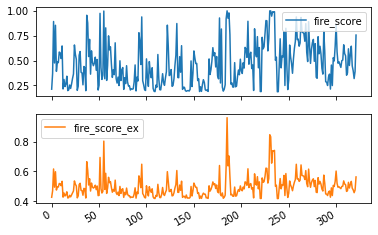

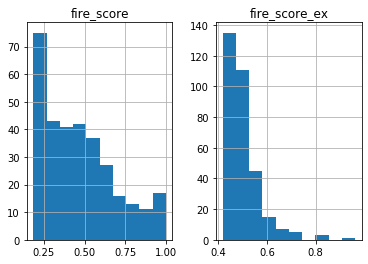

In [40]:
# Fire Risk Visualisations of Comparison
fire_risk_query = pd.read_sql_query('select fire_score,fire_score_ex from fire_risk_z_scores;', conn)
lines = fire_risk_query.plot.line(subplots=True)
lines
hist = fire_risk_query.hist(bins=10)
hist

In [41]:
conn.execute("DROP TABLE IF EXISTS fire_map")
fire_table_map = """CREATE TABLE fire_map AS(
    SELECT fire_score,fire_score_ex,ST_Transform(geom, 4326) as "geom" FROM fire_risk_z_scores)"""
conn.execute(fire_table_map)

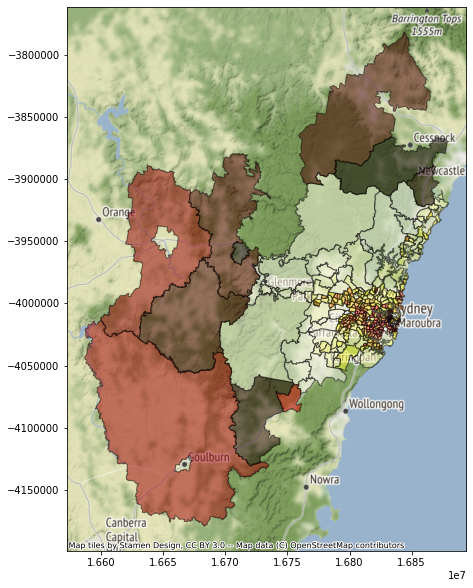

In [42]:
# Mapping Fire Scores 
import geopandas as gpd
import contextily as ctx
map_display = gpd.read_postgis("SELECT * FROM fire_map", conn)
df_wm = map_display.to_crs(epsg=3857)
ax = df_wm.plot(column = "fire_score", figsize=(10, 10), alpha=0.5, edgecolor='k',cmap = "hot_r")
ctx.add_basemap(ax)

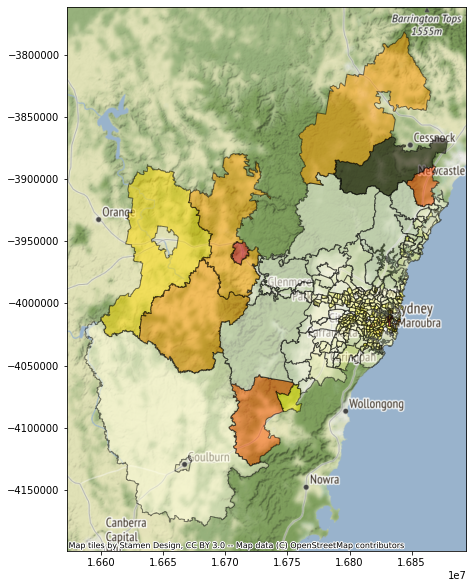

In [43]:
map_display = gpd.read_postgis("SELECT * FROM fire_map", conn)
df_wm = map_display.to_crs(epsg=3857)
ax = df_wm.plot(column = "fire_score_ex",figsize=(10, 10), alpha=0.5, edgecolor='k',cmap = "hot_r")
ctx.add_basemap(ax)

(0.14008325338521, 0.011857807674575506)

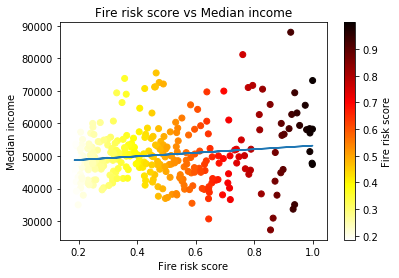

In [44]:
fire_risk_table = pd.read_sql_query('SELECT * FROM fire_risk_z_scores', conn)
import matplotlib.pyplot as plt
import numpy as np
from scipy import stats
ax = plt.scatter(fire_risk_table['fire_score'],fire_risk_table['median_income'],c = fire_risk_table['fire_score'],cmap = "hot_r")
plt.title('Fire risk score vs Median income')
plt.xlabel('Fire risk score')
plt.ylabel('Median income')
cbar = plt.colorbar(ax)
cbar.set_label('Fire risk score')
m, b = np.polyfit(fire_risk_table['fire_score'], fire_risk_table['median_income'], 1)
plt.plot(fire_risk_table['fire_score'], m*fire_risk_table['fire_score']+b)
p, p_value = stats.pearsonr(fire_risk_table['fire_score'],fire_risk_table['median_income'])
p, p_value

In [45]:
import statsmodels.formula.api as smf
reg_income = smf.ols(formula = 'median_income ~ fire_score', data = fire_risk_table).fit()
reg_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          median_income   R-squared:                       0.020
Model:                            OLS   Adj. R-squared:                  0.017
Method:                 Least Squares   F-statistic:                     6.405
Date:                Sun, 06 Jun 2021   Prob (F-statistic):             0.0119
Time:                        17:14:06   Log-Likelihood:                -3368.8
No. Observations:                 322   AIC:                             6742.
Df Residuals:                     320   BIC:                             6749.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   4.771e+04   1114.285     42.819      0.000    4.55e+04    4.99e+04
fire_score  5461.1700   2157.849      2.531      0.012    1215.808    9706.532
==============================================================================
Omnibus:                       35.355   Durbin-Watson:                   1.282
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               57.794
Skew:                           0.672   Prob(JB):                     2.82e-13
Kurtosis:                       4.581   Cond. No.                         5.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [46]:
print("RMSE: {}".format(reg_income.mse_resid**0.5))

RMSE: 8486.60225744714


(0.16835495905559852, 0.0024379704945926978)

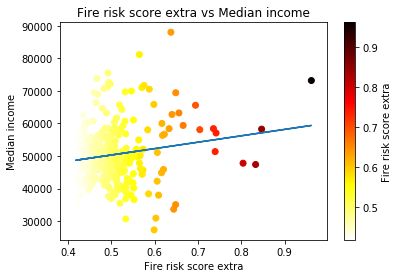

In [47]:
#fire_ex
ab = plt.scatter(fire_risk_table['fire_score_ex'],fire_risk_table['median_income'],c = fire_risk_table['fire_score_ex'],cmap = "hot_r")
cbar = plt.colorbar(ab)
cbar.set_label('Fire risk score extra')
plt.title('Fire risk score extra vs Median income')
plt.xlabel('Fire risk score extra')
plt.ylabel('Median income')
m, b = np.polyfit(fire_risk_table['fire_score_ex'], fire_risk_table['median_income'], 1)
plt.plot(fire_risk_table['fire_score_ex'], m*fire_risk_table['fire_score_ex']+b)
p, p_value = stats.pearsonr(fire_risk_table['fire_score_ex'],fire_risk_table['median_income'])
p, p_value

In [48]:
#fire_ex
reg_income = smf.ols(formula = 'median_income ~ fire_score_ex', data = fire_risk_table).fit()
reg_income.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:          median_income   R-squared:                       0.028
Model:                            OLS   Adj. R-squared:                  0.025
Method:                 Least Squares   F-statistic:                     9.334
Date:                Sun, 06 Jun 2021   Prob (F-statistic):            0.00244
Time:                        17:14:06   Log-Likelihood:                -3367.3
No. Observations:                 322   AIC:                             6739.
Df Residuals:                     320   BIC:                             6746.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      4.048e+04   3237.506     12.503      0.000    3.41e+04    4.68e+04
fire_score_ex  1.965e+04   6432.276      3.055      0.002    6997.218    3.23e+04
==============================================================================
Omnibus:                       35.991   Durbin-Watson:                   1.307
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               59.331
Skew:                           0.679   Prob(JB):                     1.31e-13
Kurtosis:                       4.605   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [49]:
#fire_ex
print("RMSE: {}".format(reg_income.mse_resid**0.5))

RMSE: 8448.775420634083


(0.043505169523483385, 0.4365661843781386)

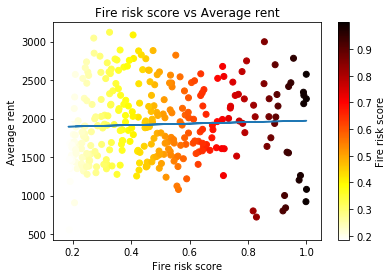

In [50]:
ac = plt.scatter(fire_risk_table['fire_score'],fire_risk_table['average_rent'],c = fire_risk_table['fire_score'],cmap = "hot_r")
cbar = plt.colorbar(ac)
cbar.set_label('Fire risk score')
plt.title('Fire risk score vs Average rent')
plt.xlabel('Fire risk score')
plt.ylabel('Average rent')
m, b = np.polyfit(fire_risk_table['fire_score'], fire_risk_table['average_rent'], 1)
plt.plot(fire_risk_table['fire_score'], m*fire_risk_table['fire_score']+b)
p, p_value = stats.pearsonr(fire_risk_table['fire_score'],fire_risk_table['average_rent'])
p, p_value

In [51]:
reg_rent = smf.ols(formula = 'average_rent ~ fire_score', data = fire_risk_table).fit()
reg_rent.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           average_rent   R-squared:                       0.002
Model:                            OLS   Adj. R-squared:                 -0.001
Method:                 Least Squares   F-statistic:                    0.6068
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.437
Time:                        17:14:07   Log-Likelihood:                -2444.8
No. Observations:                 322   AIC:                             4894.
Df Residuals:                     320   BIC:                             4901.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept   1876.9812     63.201     29.699      0.000    1752.639    2001.323
fire_score    95.3400    122.391      0.779      0.437    -145.452     336.132
==============================================================================
Omnibus:                        2.670   Durbin-Watson:                   1.238
Prob(Omnibus):                  0.263   Jarque-Bera (JB):                2.542
Skew:                           0.155   Prob(JB):                        0.281
Kurtosis:                       2.693   Cond. No.                         5.60
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [52]:
print("RMSE: {}".format(reg_rent.mse_resid**0.5))

RMSE: 481.3495627946862


(0.02809106644321771, 0.6155163162237464)

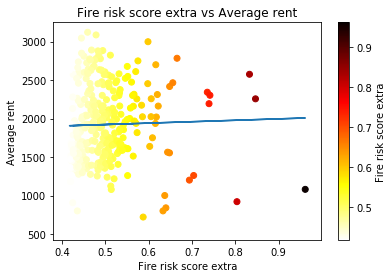

In [53]:
#fire_ex rent
ak = plt.scatter(fire_risk_table['fire_score_ex'],fire_risk_table['average_rent'],c = fire_risk_table['fire_score_ex'],cmap = "hot_r")
cbar = plt.colorbar(ak)
cbar.set_label('Fire risk score extra')
plt.title('Fire risk score extra vs Average rent')
plt.xlabel('Fire risk score extra')
plt.ylabel('Average rent')
m, b = np.polyfit(fire_risk_table['fire_score_ex'], fire_risk_table['average_rent'], 1)
plt.plot(fire_risk_table['fire_score_ex'], m*fire_risk_table['fire_score_ex']+b)
p, p_value = stats.pearsonr(fire_risk_table['fire_score_ex'],fire_risk_table['average_rent'])
p, p_value

In [54]:
#fire_ex rents
reg_rent = smf.ols(formula = 'average_rent ~ fire_score_ex', data = fire_risk_table).fit()
reg_rent.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:           average_rent   R-squared:                       0.001
Model:                            OLS   Adj. R-squared:                 -0.002
Method:                 Least Squares   F-statistic:                    0.2527
Date:                Sun, 06 Jun 2021   Prob (F-statistic):              0.616
Time:                        17:14:07   Log-Likelihood:                -2444.9
No. Observations:                 322   AIC:                             4894.
Df Residuals:                     320   BIC:                             4901.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
=================================================================================
                    coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept      1829.7701    184.551      9.915      0.000    1466.683    2192.857
fire_score_ex   184.3258    366.667      0.503      0.616    -537.056     905.708
==============================================================================
Omnibus:                        3.131   Durbin-Watson:                   1.223
Prob(Omnibus):                  0.209   Jarque-Bera (JB):                2.868
Skew:                           0.159   Prob(JB):                        0.238
Kurtosis:                       2.664   Cond. No.                         17.1
==============================================================================

Notes:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [55]:
#fire_ex rent
print("RMSE: {}".format(reg_rent.mse_resid**0.5))

RMSE: 481.61559964975424


In [56]:
conn.close()
db.dispose()